In [1]:
from cyberbattle.simulation import model as m
from cyberbattle.simulation import actions
from cyberbattle.simulation.model import NodeID, NodeInfo, VulnerabilityID, VulnerabilityInfo
from typing import Dict, Iterator, cast, Tuple

default_allow_rules = [
    m.FirewallRule("SSH", m.RulePermission.ALLOW),
]

# Network nodes involved in the Capture the flag game
nodes = {
    "Website": m.NodeInfo(
        services=[
            m.ListeningService("SSH", allowedCredentials=[
                "ReusedMySqlCred-web"])],
        firewall=m.FirewallConfiguration(incoming=default_allow_rules,
                                         outgoing=default_allow_rules + [
                                             m.FirewallRule("su", m.RulePermission.ALLOW),
                                             m.FirewallRule("sudo", m.RulePermission.ALLOW)]),
        value=1000,
        properties=["MySql", "Ubuntu", "nginx/1.10.3"],
        owned_string="FLAG: Login using insecure SSH user/password",
        vulnerabilities=dict(
            ScanPageSource=m.VulnerabilityInfo(
                description="Website page source contains refrence to browseable "
                            "relative web directory",
                type=m.VulnerabilityType.REMOTE,
                outcome=m.LeakedNodesId(["Website.Directory"]),
                reward_string="Viewing the web page source reveals a URL to a .txt file and directory on the website",
                cost=1.0
            ),
        )),

    "Website.Directory": m.NodeInfo(
        services=[m.ListeningService("HTTPS"), m.ListeningService("SSH", allowedCredentials=[
                "ReusedMySqlCred-web"])],
        value=50,
        properties=["Ubuntu", "nginx/1.10.3",
                    "CTFFLAG:Readme.txt-Discover secret data"
                    ],
        vulnerabilities=dict(
            NavigateWebDirectoryFurther=m.VulnerabilityInfo(
                description="Discover MYSQL credentials MySql for user "
                            "'web' in (getting-started.txt)",
                type=m.VulnerabilityType.REMOTE,
                outcome=m.LeakedCredentials(credentials=[
                    m.CachedCredential(node="Website", port="MySQL",
                                       credential="ReusedMySqlCred-web")]),
                reward_string="Discover browseable web directory: Navigating to parent URL revealed file `readme.txt`"
                              "with secret data (aflag); and `getting-started.txt` with MYSQL credentials",
                cost=1.0
            ),
        )),


    'client': m.NodeInfo(
        services=[],
        properties=["CLIENT:Win10"],
        value=0,
        vulnerabilities=dict(
            SearchEdgeHistory=m.VulnerabilityInfo(
                description="Search web history for list of accessed websites",
                type=m.VulnerabilityType.LOCAL,
                outcome=m.LeakedNodesId(["Website"]),
                reward_string="Web browser history revealed website URL of interest",
                cost=1.0
            )),
        agent_installed=True,
        reimagable=False),
}

global_vulnerability_library: Dict[VulnerabilityID, VulnerabilityInfo] = dict([])

# Environment constants
ENV_IDENTIFIERS = m.infer_constants_from_nodes(
    cast(Iterator[Tuple[NodeID, NodeInfo]], list(nodes.items())),
    global_vulnerability_library)

In [2]:
import networkx as nx
network = nx.DiGraph()
network.add_nodes_from([(k, {'data': v}) for (k, v) in list(nodes.items())])
network.add_edge("Website", "Website.Directory", kind=actions.EdgeAnnotation.REMOTE_EXPLOIT)
network.add_edge("client", "Website", kind=actions.EdgeAnnotation.REMOTE_EXPLOIT)
print(network.nodes)
print(network.edges)
(list(network.edges)[1])

['Website', 'Website.Directory', 'client']
[('Website', 'Website.Directory'), ('client', 'Website')]


('client', 'Website')

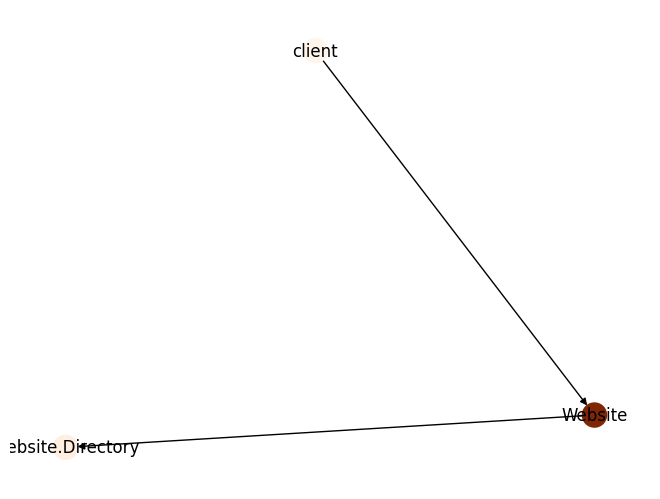

In [3]:
import cyberbattle.simulation.model as model
import cyberbattle.simulation.commandcontrol as commandcontrol

env = model.Environment(network=network, vulnerability_library=dict([]),identifiers=ENV_IDENTIFIERS)
env.plot_environment_graph()

In [4]:
c2 = commandcontrol.CommandControl(env)
dbg = commandcontrol.EnvironmentDebugging(c2)
c2.print_all_attacks()

,status,properties,local_attacks,remote_attacks
id,,,,
client,owned,[CLIENT:Win10],[SearchEdgeHistory],[]


In [5]:
# Discover website
outcome = c2.run_attack('client', 'SearchEdgeHistory')
print(outcome)
c2.print_all_attacks()

,status,properties,local_attacks,remote_attacks
id,,,,
client,owned,[CLIENT:Win10],[SearchEdgeHistory],[]
Website,discovered,NaN,None,[ScanPageSource]


In [6]:
# Discover Website.Directory
outcome = c2.run_remote_attack('client', 'Website', 'ScanPageSource')
print(outcome)
c2.print_all_attacks()

,status,properties,local_attacks,remote_attacks
id,,,,
client,owned,[CLIENT:Win10],[SearchEdgeHistory],[]
Website,discovered,NaN,None,[ScanPageSource]
Website.Directory,discovered,NaN,None,[NavigateWebDirectoryFurther]


In [7]:
# Leak credential from Website.Directory that can be used to connect to Website and Website.Directory
outcome = c2.run_remote_attack('client', 'Website.Directory', 'NavigateWebDirectoryFurther')
print(outcome)
print(c2.credentials_gathered_so_far)
c2.print_all_attacks()

{CachedCredential(node='Website', port='MySQL', credential='ReusedMySqlCred-web')}


,status,properties,local_attacks,remote_attacks
id,,,,
client,owned,[CLIENT:Win10],[SearchEdgeHistory],[]
Website,discovered,NaN,None,[ScanPageSource]
Website.Directory,discovered,NaN,None,[NavigateWebDirectoryFurther]


In [8]:
# This fails here because Website is not owned
c2.connect_and_infect('Website', 'Website.Directory', 'SSH', 'ReusedMySqlCred-web')
c2.print_all_attacks()

ValueError: Agent does not owned the source node 'Website'

In [ ]:
# This gives the agent ownership of website
c2.connect_and_infect('client', 'Website', 'SSH', 'ReusedMySqlCred-web')
c2.print_all_attacks()

In [ ]:
# This fails because client is not connected to Website.Directory
c2.connect_and_infect('client', 'Website.Directory', 'SSH', 'ReusedMySqlCred-web')
c2.print_all_attacks()

In [ ]:
# This succeeds now because the agent owns website and Website is connected to Website.Directory
c2.connect_and_infect('Website', 'Website.Directory', 'SSH', 'ReusedMySqlCred-web')
c2.print_all_attacks()